# Data processing and visualization

## 1. Combine data & calculate RMSE

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt

days = 32
discretization = 2
obs_per_day = 1
nobs = days * obs_per_day
MAGI_niter = 15001
N = 100000.
X = np.arange(0, days, 1. / (obs_per_day * discretization))
i0 = 50
e0 = 100
T = 2
parameter_value = [1.8, 0.1, 0.1, 0.05]
std = [1., 0.02, 0, 0.025]


tmp_2 = np.linspace(0, 2 * T * np.pi, nobs)
true_re_2 = parameter_value[0] - std[0] * np.cos(tmp_2)
true_ve_2 = parameter_value[1]- std[1] * np.cos(tmp_2)
true_vi_2 = parameter_value[2]
true_pd_2 = parameter_value[3] + std[3] * np.cos(tmp_2)
theta_true = np.vstack([true_re_2, true_ve_2, true_pd_2]).T

tmp = np.linspace(0, 2 * T * np.pi, nobs)
true_re = parameter_value[0] - std[0] * np.cos(tmp)
true_ve = parameter_value[1]- std[1] * np.cos(tmp)
true_vi = parameter_value[2] 
true_pd = parameter_value[3] + std[3] * np.cos(tmp)

all_beta = np.zeros((100, 32))
all_ve = np.zeros((100, 32))
all_pd = np.zeros((100, 32))
all_vi = np.zeros(100)
all_xinit = np.zeros((100, 4))
RMSE_beta = np.zeros(100)
for i in range(100):
    file = np.load('G:/SEIR-RK/beta-'+str(i)+'.npy')
    all_beta[i] = file

for i in range(100):
    file = np.load('G:/SEIR-RK/ve-'+str(i)+'.npy')
    all_ve[i] = file  
    
for i in range(100):
    file = np.load('G:/SEIR-RK/pd-'+str(i)+'.npy')
    all_pd[i] = file  

for i in range(100):
    file = np.load('G:/SEIR-RK/vi-'+str(i)+'.npy')
    all_vi[i] = file 

for i in range(100):
    file = np.load('G:/SEIR-RK/xinit-'+str(i)+'.npy')
    all_xinit[i] = file
RMSE_beta = np.sqrt(np.mean(np.square(all_beta - true_re_2), axis=0))
print(np.mean(RMSE_beta), np.std(RMSE_beta))
RMSE_ve = np.sqrt(np.mean(np.square(all_ve - true_ve_2), axis=0))
print(np.mean(RMSE_ve), np.std(RMSE_ve))
RMSE_vi = np.abs(all_vi - true_vi_2)
print(np.mean(RMSE_vi), np.std(RMSE_vi))
RMSE_pd = np.sqrt(np.mean(np.square(all_pd / 4 - true_pd_2), axis=0))
print(np.mean(RMSE_pd), np.std(RMSE_pd))

0.17853875090444465 0.09413145788400458
0.05146538802555186 0.030003112918573042
0.004667082580027296 0.002998290344469203
0.04520988180399987 0.018062367178397747


In [7]:
all_beta.shape

(100, 32)

## 2. Visualization of parameters

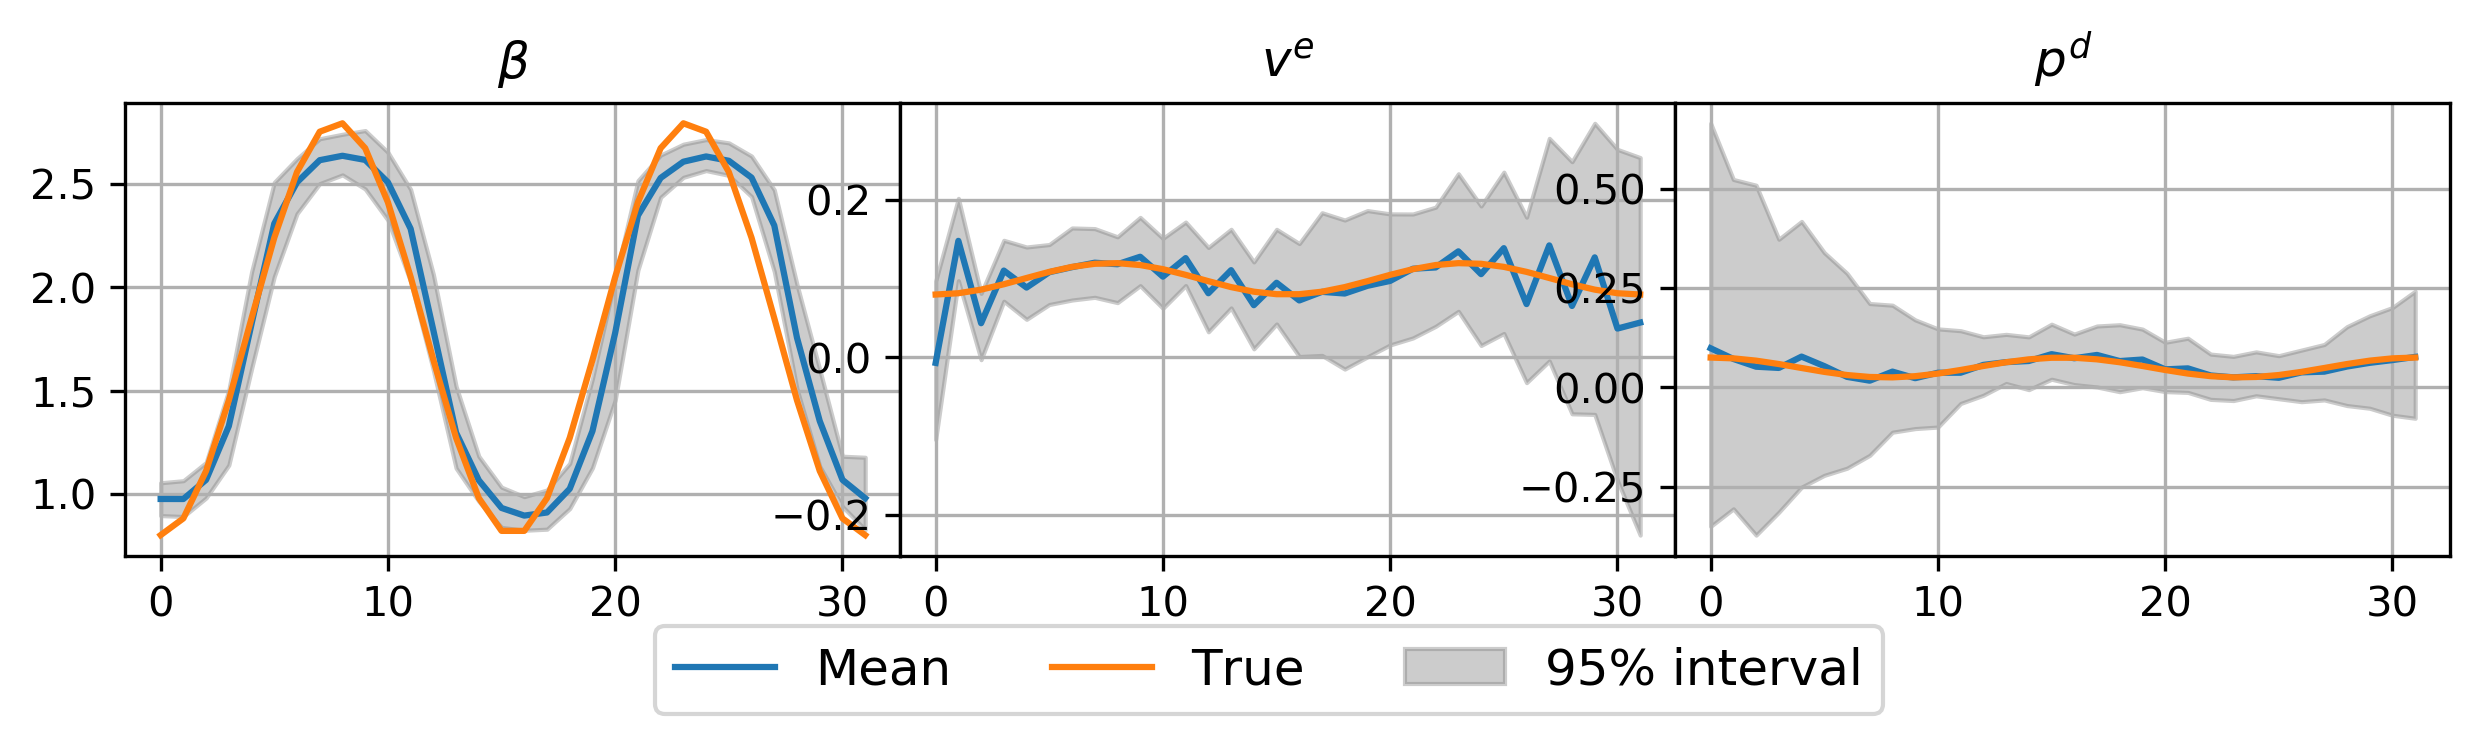

In [9]:
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 2)
plt.subplots_adjust(wspace =0, hspace =0)
ax1 = plt.subplot(1, 3, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_beta, 97.5, axis=0)
upper_95 = np.percentile(all_beta, 2.5, axis=0)
x = np.arange(0, 32, 1)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(x, np.mean(all_beta, axis=0), label='Mean')
plt.plot(true_re, label='True')
plt.title(r'$\beta$')
plt.grid()
plt.legend(bbox_to_anchor=(2.3, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 3, 2)
lower_95 = np.percentile(all_ve, 97.5, axis=0)
upper_95 = np.percentile(all_ve, 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(x, np.mean(all_ve, axis=0))
plt.plot(true_ve)
plt.grid()
plt.title(r'$v^e$')


ax3 = plt.subplot(1, 3, 3)
lower_95 = np.percentile(all_pd, 97.5, axis=0)
upper_95 = np.percentile(all_pd, 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(x, np.mean(all_pd, axis=0))
plt.plot(true_pd)
plt.title(r'$p^d$')
plt.grid()

## 3. Recover data

In [10]:
def recover_data(beta, ve, pd, vi, state0, days=32, obs_per_day=1, discretization = 1, linspace=1000, mode='Linear'):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    freq = 1. / discretization
    nFull = int(days * obs_per_day)
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 4))
    state_ls[0][0] = state0[0]
    state_ls[0][1] = state0[1]
    state_ls[0][2] = state0[2]
    state_ls[0][3] = state0[3]
    # Use linear interpolation for theta
    if mode == 'Linear': 
        x_initial = np.linspace(0, 1000, beta.shape[0])
        x_interp = np.linspace(0, 1000, 32000)
        beta_interp = np.interp(x_interp, x_initial, beta)
        ve_interp = np.interp(x_interp, x_initial, ve)
        pd_interp = np.interp(x_interp, x_initial, pd)
    # Use Gaussian interpolation for theta    
    elif mode == 'Gaussian':
        from scipy.interpolate import Rbf
        x = np.linspace(0, 100, beta.shape[0])
        x_interp = np.linspace(0, 100, 32000)
        rbf_beta = Rbf(x, beta, epsilon=10, function='gaussian')
        rbf_ve = Rbf(x, ve, epsilon=10, function='gaussian')
        rbf_pd = Rbf(x, pd, epsilon=10, function='gaussian')
        beta_interp = rbf_beta(x_interp) 
        ve_interp = rbf_ve(x_interp)
        pd_interp = rbf_pd(x_interp)
    else:
        raise ValueError
        
        
    for i in range(1, linspace * nFull):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] - step_size * beta_interp[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * beta_interp[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * ve_interp[index] * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * ve_interp[index] * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * vi
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * vi * pd_interp[index]
#     states = state_ls[::int(linspace / discretization)]
    return state_ls


all_reconstructed_x = np.zeros((100, 32000, 4))
for i in range(100):
    print(i)
    all_reconstructed_x[i] = recover_data(all_beta[i], all_ve[i], all_pd[i], all_vi[i], np.exp(all_xinit[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


## 4. True data

In [11]:
def true_data(days=32, obs_per_day=1, state0=[100000., 100., 50., 50.], linspace=1000):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    parameter_value = [1.8, 0.1, 0.1, 0.05]
    std = [1., 0.02, 0, 0.025]
    tmp = np.linspace(0, 2 * T * np.pi, 32000)
    true_re = parameter_value[0] - std[0] * np.cos(tmp)
    true_ve = parameter_value[1]- std[1] * np.cos(tmp)
    true_vi = parameter_value[2] 
    true_pd = parameter_value[3] + std[3] * np.cos(tmp)
    nFull = int(days * obs_per_day)
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 4))
    state_ls[0][0] = state0[0]
    state_ls[0][1] = state0[1]
    state_ls[0][2] = state0[2]
    state_ls[0][3] = state0[3]

    for i in range(1, linspace * nFull):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] - step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * true_ve[index] * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * true_ve[index] * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * true_vi
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * true_vi  * true_pd[index]
    states = state_ls[::linspace]
    return states

true_x = true_data()
true_x

array([[1.00000000e+05, 1.00000000e+02, 5.00000000e+01, 5.00000000e+01],
       [9.99571525e+04, 1.33476557e+02, 5.41824154e+01, 5.03857686e+01],
       [9.99011332e+04, 1.76643597e+02, 6.12909975e+01, 5.07912735e+01],
       [9.98177422e+04, 2.41614832e+02, 7.30440138e+01, 5.12158373e+01],
       [9.96857153e+04, 3.45756180e+02, 9.27273692e+01, 5.16641612e+01],
       [9.94703981e+04, 5.16912554e+02, 1.26095735e+02, 5.21488671e+01],
       [9.91140083e+04, 8.01313684e+02, 1.82888184e+02, 5.26951891e+01],
       [9.85239427e+04, 1.27267873e+03, 2.78916255e+02, 5.33562761e+01],
       [9.75657351e+04, 2.03664793e+03, 4.37965090e+02, 5.42559911e+01],
       [9.60757419e+04, 3.21769208e+03, 6.91388425e+02, 5.56835898e+01],
       [9.39125168e+04, 4.91313828e+03, 1.07218908e+03, 5.82532884e+01],
       [9.10457137e+04, 7.11753927e+03, 1.60217434e+03, 6.30825297e+01],
       [8.76303793e+04, 9.66479585e+03, 2.27741643e+03, 7.18436100e+01],
       [8.39821807e+04, 1.22601244e+04, 3.06398194e

## 5. Visualization of $x(t)$ using linear interpolation

1084.8637953192085 195.34051588650541
951.7715530151478 142.35025785060023
556.2811631301407 90.69932296033794
33.36620157360693 5.066100306998075


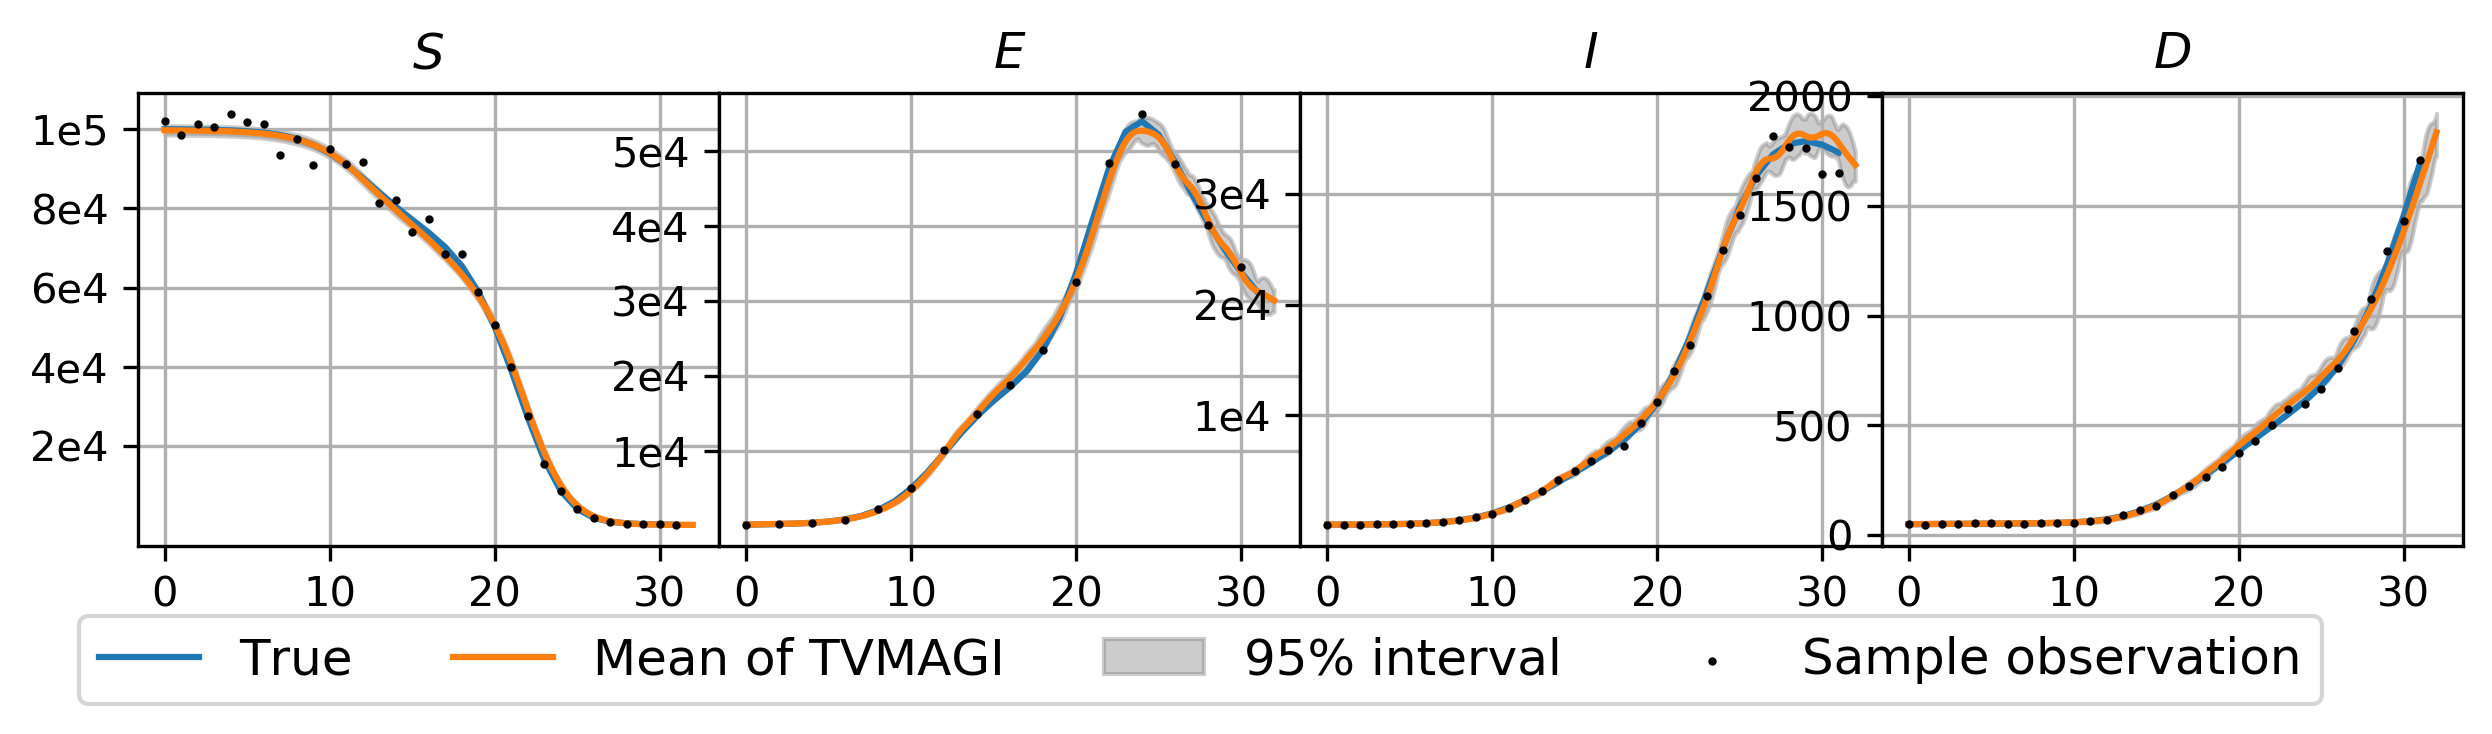

In [16]:
yobs = np.exp(np.load('G:/TVMAGI-2/SEIRD observations.npy')[1])
figsize(10, 2)
plt.subplots_adjust(wspace =0, hspace =0)
ax1 = plt.subplot(1, 4, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_reconstructed_x[:,:, 0], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 0], 2.5, axis=0)
x = np.arange(0, 32, 0.001)
plt.yticks(np.array([20000, 40000, 60000, 80000, 100000]), ['2e4', '4e4', '6e4', '8e4', '1e5'])
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(true_x[:, 0], label='True')
plt.plot(x, np.mean(all_reconstructed_x[:,:, 0], axis=0), label='Mean of TVMAGI')
plt.scatter(np.arange(0, 32,1), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$S$')
plt.legend(bbox_to_anchor=(3.8, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 2)
lower_95 = np.percentile(all_reconstructed_x[:,:, 1], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 1], 2.5, axis=0)
plt.yticks(np.array([10000, 20000, 30000, 40000, 50000]), ['1e4', '2e4', '3e4', '4e4', '5e4'])
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(true_x[:, 1])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 1], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 1], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$E$')


ax3 = plt.subplot(1, 4, 3)
lower_95 = np.percentile(all_reconstructed_x[:,:, 2], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 2], 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.yticks(np.array([10000, 20000, 30000]), ['1e4', '2e4', '3e4'])
plt.plot(true_x[:, 2])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 2], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 2], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$I$')


ax4= plt.subplot(1, 4, 4)
lower_95 = np.percentile(all_reconstructed_x[:,:, 3], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 3], 2.5, axis=0)
# plt.yticks(np.array([250,500,750,1000,1250,1500]))
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(true_x[:, 3])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 3], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 3], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$D$')

RMSE_S = np.zeros(100)
RMSE_E = np.zeros(100)
RMSE_I = np.zeros(100)
RMSE_D = np.zeros(100)

for i in range(100):
    RMSE_S[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::1000, 0] - true_x[:, 0])))
    RMSE_E[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::1000, 1] - true_x[:, 1])))
    RMSE_I[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::1000, 2] - true_x[:, 2])))
    RMSE_D[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::1000, 3] - true_x[:, 3])))
    
print(np.mean(RMSE_S), np.std(RMSE_S))
print(np.mean(RMSE_E), np.std(RMSE_E))
print(np.mean(RMSE_I), np.std(RMSE_I))
print(np.mean(RMSE_D), np.std(RMSE_D))